In [23]:
import pandas as pd
import numpy as np
from pathlib import Path

import getpass
pd.options.mode.chained_assignment = None

In [2]:
# Ruta para pcs
user = getpass.getuser() # Capturo el usuario local / Ejemplo "Llan_", este es el nombre de mi usuario que inicie sesion en la pc

if   user== "analistaup29": # PC Analista UP 29 Minedu
     work = Path(r"C:\Users\ANALISTAUP29\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user== "llan_": # PC casa Llan
     work = Path(r"C:\Users\llan_\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user == "USUARIO": # @hugoferquiroz casa
     work =  Path(r'D:\\Trabajo\AITeacherAllocation') 

In [3]:
df = pd.read_csv(work/r'Results\\Base consolidada.csv')
df.set_index(['cod_mod','year'],inplace=True)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_29972\3606240390.py:1: DtypeWarning: Columns (1,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(work/r'Results\\Base consolidada.csv')


# Target population

The goal is predict teacher allocation in this population target:

- Educational stage
    - Kindergarten 
    - Primary school

- Teachers:
    - Teachers
    - Education Assistant

- Type of school 
    - Public managed by Central Goverment

In [4]:
# Relevant rows
df = df.loc[df['niv_mod']!='F0'] # Educational stage
df = df.dropna(subset=['region']) # Drop missing in region
df = df.loc[(df['gestion']==1) & (df['ges_dep']=='A1')] # Type of school
df = df.loc[df['estado']==1] # Active in 2022

In [5]:
# Repair educational stage
df.loc[df['d_niv_mod']=='Inicial - Jard¡n','d_niv_mod'] = 'Inicial - Jardin'
df.loc[df['d_niv_mod']=='Inicial - Cuna-jard¡n','d_niv_mod'] = 'Inicial - Cuna-jardin'
# Drop few observations 
df = df.loc[df['d_niv_mod']!='Inicial - Cuna'] # 39 rows deleted
# Drop no relevant information in target variable
df = df.loc[df['secciones_necesarias']!=0] #720 rows deleted

# Data for clusters
Divede the data for educational stage beacuse our objective is identify groups by educational stage

In [6]:
df['d_niv_mod'].value_counts()

Primaria                 87339
Inicial - Jardin         71487
Inicial - Cuna-jardin     1261
Name: d_niv_mod, dtype: int64

In [7]:
def drop_no_relevant(df):
    '''
    Drop no relevant columns
    df: 
        - type: data frame
    '''
    df = df.drop(columns=['Unnamed: 0.1','usuario_minedu','bolsa_nexus','bolsa_sira',
'dir_req', 'sub_dir_req','jer_req','fisica_req','aip_req','dir_exd','sub_dir_exd',
'jer_exd','niv_mod','gestion','d_gestion','ges_dep','d_ges_dep','estado',
'd_estado','d_region','tipo_entidad','jec','Unnamed: 0','otro_doc_exd','d_dpto','codlocal','d_dist','d_niv_mod',]) 
    df['doc_exd']= df['doc_aula_exd_n']+df['doc_aula_exd_c']
    df = df.drop(columns=['doc_aula_exd_n', 'doc_aula_exd_c'])
    return df

## Primary level

In [66]:
# Primary
df_primaria = df.loc[df['d_niv_mod']=='Primaria']
df_primaria = drop_no_relevant(df_primaria)
# Enrollment in primary is 1 - 6
enrolment_no_primary = [ x for x in df_primaria.columns.to_list() if (x.find('cant0')!=-1) | (x.find('inclu0')!=-1) ]
df_primaria = df_primaria.drop(columns=enrolment_no_primary)

In [67]:
num_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'int64') | (df_primaria[x].dtype =='float64') ]
str_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'object') ]

### Missing

In [68]:
df_primaria[['nlat_ie','nlong_ie']].isnull().sum()

nlat_ie     0
nlong_ie    0
dtype: int64

In [69]:
df_primaria[str_primaria].isnull().sum()

d_prov            0
d_dreugel         0
region            0
ruralidad         0
vraem             0
frontera          0
bilingue          0
caracteristica    0
dtype: int64

<AxesSubplot:ylabel='cod_mod-year'>

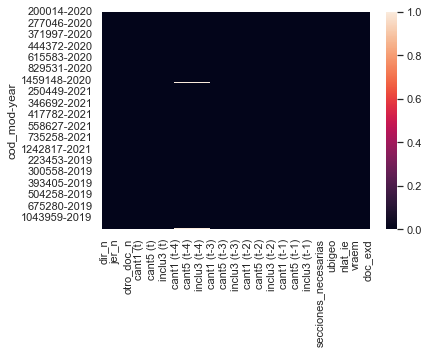

In [70]:
# Inspecting missing
import seaborn as sns
sns.heatmap(df_primaria.isnull())

In [71]:
# Imputing missing
df_primaria.fillna(0,inplace=True)

### Feature selection

In [72]:
# Labor force
df_primaria['Directores'] = df_primaria['dir_n'] + df_primaria['dir_c']
df_primaria['Subdirectores'] = df_primaria['sub_dir_n'] + df_primaria['sub_dir_c']
df_primaria['Jerarquicos'] = df_primaria['jer_n'] + df_primaria['jer_c']
df_primaria['Docentes de aula'] = df_primaria['doc_aula_n'] + df_primaria['doc_aula_c']
df_primaria['Otros docentes'] = df_primaria['otro_doc_n'] + df_primaria['otro_doc_c']
df_primaria['Auxiliares'] = df_primaria['aux_n'] + df_primaria['aux_c']
personal = ['Directores','Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']

In [73]:
# Enrollment
periodos = ['t','t-1','t-2','t-3','t-4']
# Total Enrollment
for i in periodos:
    df_primaria[f'Matricula regular total {i}']=df_primaria[f'cant1 ({i})']+df_primaria[f'cant2 ({i})']+df_primaria[f'cant3 ({i})']+df_primaria[f'cant4 ({i})']+df_primaria[f'cant5 ({i})']+df_primaria[f'cant6 ({i})']
    df_primaria[f'Matricula inclusiva total {i}']=df_primaria[f'inclu1 ({i})']+df_primaria[f'inclu2 ({i})']+df_primaria[f'inclu3 ({i})']+df_primaria[f'inclu4 ({i})']+df_primaria[f'inclu5 ({i})']+df_primaria[f'inclu6 ({i})']

# Growth rate enrollment
# Method 1
#df_primaria["tasa_c_anual_regular"]=((df_primaria['Matricula regular total t']/df_primaria['Matricula regular total t-4'])**(1/4))-1
#df_primaria["tasa_c_anual_inclusivo"]=((df_primaria['Matricula inclusiva total t']/df_primaria['Matricula inclusiva total t-4'])**(1/4))-1
# Method 2
df_primaria['tasa_c_anual_regular'] = ((df_primaria['Matricula regular total t']+df_primaria['Matricula regular total t-1'])+
                                        (df_primaria['Matricula regular total t-1']+df_primaria['Matricula regular total t-2'])+
                                        (df_primaria['Matricula regular total t-3']+df_primaria['Matricula regular total t-4']))/3



In [74]:
num_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'int64') | (df_primaria[x].dtype =='float64') ]

### Finding optimal clusters

In [75]:
# Determino la cantidad de clusters
from sklearn.cluster import KMeans

In [76]:
df_primaria_knn = df_primaria[num_primaria]

In [77]:
## Vamos a hacer el grafico del codo. Para esto vamos a probar hacer distintos clusters y vamos a guardar el error (que lo definimos como wcss)
# WCSS --> Wihin Cluster Sum of Squares
wcss = []
for i in range(1,12):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=36963)
  kmeans.fit(df_primaria_knn)
  wcss.append(kmeans.inertia_)

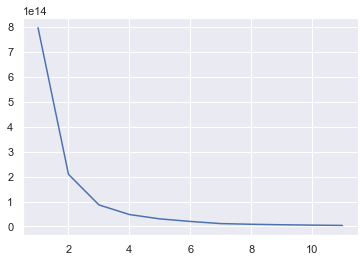

In [78]:
import matplotlib.pyplot as plt
sns.set()
plt.plot(range(1,12),wcss)

In [91]:
## El numero optimo de clusters es igual a 5, asi que haremos 5 clusters
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=36963)
kmeans.fit(df_primaria_knn)
clusters = kmeans.predict(df_primaria_knn)

In [92]:
for i in range(7):
    print(f'Cluster numero {i}')
    print((df_primaria_knn.loc[df_primaria_knn['Segmento']==i,personal]).describe().transpose())

Cluster numero 0
                    count      mean       std  min  25%  50%   75%   max
Directores        12443.0  0.213936  0.411077  0.0  0.0  0.0   0.0   2.0
Subdirectores     12443.0  0.166198  0.438310  0.0  0.0  0.0   0.0   3.0
Jerarquicos       12443.0  0.000321  0.017927  0.0  0.0  0.0   0.0   1.0
Docentes de aula  12443.0  6.841035  9.016495  0.0  1.0  2.0  10.0  80.0
Otros docentes    12443.0  0.653058  1.353856  0.0  0.0  0.0   1.0  11.0
Auxiliares        12443.0  0.000000  0.000000  0.0  0.0  0.0   0.0   0.0
Cluster numero 1
                    count      mean       std  min  25%  50%  75%   max
Directores        16689.0  0.247828  0.431764  0.0  0.0  0.0  0.0   1.0
Subdirectores     16689.0  0.036611  0.219582  0.0  0.0  0.0  0.0   3.0
Jerarquicos       16689.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
Docentes de aula  16689.0  3.565342  4.902642  0.0  1.0  2.0  4.0  56.0
Otros docentes    16689.0  0.245251  0.766602  0.0  0.0  0.0  0.0   9.0
Auxiliares        16689

In [80]:
df_primaria_knn['Segmento'] = clusters

In [82]:
# Caraterizar los clusters
df_primaria_knn.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dir_n,87339.0,0.174825,0.379819,0.0,0.0,0.000000,0.0,1.000000
dir_c,87339.0,0.061290,0.239863,0.0,0.0,0.000000,0.0,1.000000
sub_dir_n,87339.0,0.040669,0.201142,0.0,0.0,0.000000,0.0,2.000000
sub_dir_c,87339.0,0.021869,0.169398,0.0,0.0,0.000000,0.0,5.000000
jer_n,87339.0,0.000023,0.004785,0.0,0.0,0.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...
Matricula inclusiva total t-3,87339.0,1.389734,3.250640,0.0,0.0,0.000000,1.0,86.000000
Matricula regular total t-4,87339.0,85.262930,162.811232,0.0,13.0,30.000000,71.0,1961.000000
Matricula inclusiva total t-4,87339.0,1.403176,3.268476,0.0,0.0,0.000000,1.0,86.000000
tasa_c_anual_regular,87339.0,175.744955,342.326580,0.0,25.0,56.666667,139.0,4440.666667


In [81]:
df_primaria_knn[personal].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Directores,87339.0,0.236114,0.424965,0.0,0.0,0.0,0.0,2.0
Subdirectores,87339.0,0.062538,0.287886,0.0,0.0,0.0,0.0,6.0
Jerarquicos,87339.0,0.000137,0.011721,0.0,0.0,0.0,0.0,1.0
Docentes de aula,87339.0,4.302912,6.313760,0.0,1.0,2.0,4.0,80.0
Otros docentes,87339.0,0.333608,0.934679,0.0,0.0,0.0,0.0,12.0
Auxiliares,87339.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
'cant1 (t)',
 'cant2 (t)',
 'cant3 (t)',
 'cant4 (t)',
 'cant5 (t)',
 'cant6 (t)'


 'inclu1 (t)',
 'inclu2 (t)',
 'inclu3 (t)',
 'inclu4 (t)',
 'inclu5 (t)',
 'inclu6 (t)',

In [21]:
num_primaria

['dir_n',
 'dir_c',
 'sub_dir_n',
 'sub_dir_c',
 'jer_n',
 'jer_c',
 'doc_aula_n',
 'doc_aula_c',
 'otro_doc_n',
 'otro_doc_c',
 'aux_n',
 'aux_c',
 'cant1 (t)',
 'cant2 (t)',
 'cant3 (t)',
 'cant4 (t)',
 'cant5 (t)',
 'cant6 (t)',
 'inclu1 (t)',
 'inclu2 (t)',
 'inclu3 (t)',
 'inclu4 (t)',
 'inclu5 (t)',
 'inclu6 (t)',
 'cant1 (t-4)',
 'cant2 (t-4)',
 'cant3 (t-4)',
 'cant4 (t-4)',
 'cant5 (t-4)',
 'cant6 (t-4)',
 'inclu1 (t-4)',
 'inclu2 (t-4)',
 'inclu3 (t-4)',
 'inclu4 (t-4)',
 'inclu5 (t-4)',
 'inclu6 (t-4)',
 'cant1 (t-3)',
 'cant2 (t-3)',
 'cant3 (t-3)',
 'cant4 (t-3)',
 'cant5 (t-3)',
 'cant6 (t-3)',
 'inclu1 (t-3)',
 'inclu2 (t-3)',
 'inclu3 (t-3)',
 'inclu4 (t-3)',
 'inclu5 (t-3)',
 'inclu6 (t-3)',
 'cant1 (t-2)',
 'cant2 (t-2)',
 'cant3 (t-2)',
 'cant4 (t-2)',
 'cant5 (t-2)',
 'cant6 (t-2)',
 'inclu1 (t-2)',
 'inclu2 (t-2)',
 'inclu3 (t-2)',
 'inclu4 (t-2)',
 'inclu5 (t-2)',
 'inclu6 (t-2)',
 'cant1 (t-1)',
 'cant2 (t-1)',
 'cant3 (t-1)',
 'cant4 (t-1)',
 'cant5 (t-1)',
 'ca

In [37]:
# Enrollment in primary is 1 - 6
enrolment_no_primary = [ x for x in df_primaria.columns.to_list() if (x.find('cant0')!=-1) | (x.find('inclu0')!=-1) ]

In [7]:
# Other outcomes not relevant to predict in this version
other_outcomes=['doc_aula_req','aux_req','doc_aula_exd_n', 'doc_aula_exd_c', 'aux_exd']
#df = df.drop(columns=other_outcomes)

In [ ]:
# Reducir la dimensionalidad?